In [1]:
clear all

In [2]:
import nibabel as nb
import os
import numpy as np
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askdirectory
import libtiff 
import matplotlib.pyplot as plt
from Tkinter import Tk
from tkFileDialog import askopenfilename
#import cv2
%matplotlib inline

# Get video time (output from matlab)

In [3]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)
Tvid=Ua['Time']
Tvid.shape

/media/sophie/b8465819-f4b4-489a-80f2-dbd85351bec1/THDDCGCaMP6/100404series/170618/thddcgcamp6fgcamp6f/control3_2017-06-18-183059-0000Time.mat


(1, 7051)

# Get head video data

Open the head saved as 32bit nii

In [4]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

/media/sophie/b8465819-f4b4-489a-80f2-dbd85351bec1/THDDCGCaMP6/100404series/control3_2017-06-18-183059-0000head.nii


(21, 14, 7051, 1)

In [5]:
# Find end of onset of light and begining of offset (to align to behavior) 

In [6]:
M=np.mean(np.mean(data,0),0)
M=M-np.min(M)
Mav=M.mean()
M=M/Mav

In [7]:
M.shape

(7051, 1)

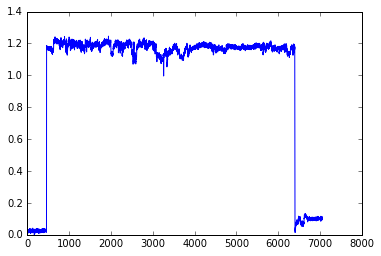

In [8]:
plt.plot(M)

In [9]:
liston=[i for i in range(len(M)) if M[i]>0.5]
#liston[0]
max(liston)

6394

In [10]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

In [11]:
Ms=M[range(liston[0]-8,liston[0]+8)]-M[liston[0]-8]

In [12]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [13]:
liston[0]-8

454

In [18]:
res = scipy.optimize.minimize(Sq,x0=[7.6,0.00,8.6,1.3])

In [19]:
ON=liston[0]-8+res.x[2]
print(ON)

462.518098682


In [20]:
ONint=np.int(np.ceil(ON))
print(ONint)

463


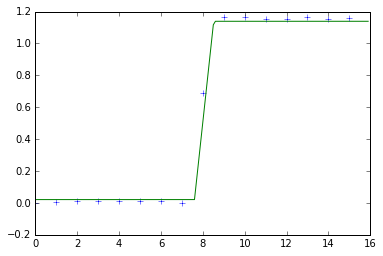

In [21]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

Model offset and find precise offset time

In [22]:
len(M)

7051

In [23]:
Ms=M[range(max(liston)-6,max(liston)+6)]

In [24]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [28]:
res = scipy.optimize.minimize(Sq,x0=[5.9,1.1,6.9,-1])

In [29]:
OFF=liston[len(liston)-1]-6+res.x[0]
#OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

6393.88960607
6393


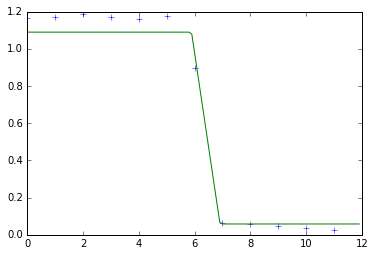

In [30]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

# Save times were light is on

In imageJ: choose subsack between these 2 values

In [31]:
print(ONint+1)
print(OFFint+1)
print(ON)
print(OFF)
print(OFFint-ONint)
print(OFF-ON)

464
6394
462.518098682
6393.88960607
5930
5931.37150738


In [32]:
TimeOn=[Tvid.T[i] for i in range(ONint,(OFFint+1))]

In [33]:
Tinit=(ON-(ONint-1))*(Tvid.T[ONint]-Tvid.T[ONint-1])+Tvid.T[ONint-1]

In [34]:
Toff=(OFF-OFFint)*(Tvid.T[OFFint+1]-Tvid.T[OFFint])+Tvid.T[OFFint]

In [35]:
Toff-Tinit  

array([ 59882.3874979])

In [36]:
np.mean((Tvid.T[100:(len(Tvid.T))])-np.array(Tvid.T[99:(len(Tvid.T)-1)]))


10.087779466261976

In [37]:
np.std((Tvid.T[100:(len(Tvid.T))])-np.array(Tvid.T[99:(len(Tvid.T)-1)]))


1.856425769308313

In [38]:
#Ttest=np.array(Tvid.T[2:(len(Tvid.T))])-np.array(Tvid.T[1:(len(Tvid.T)-1)])
#plt.plot(Ttest)
#plt.axis([0,100,19.5,150])

In [39]:
TimeOnFinal=(np.array(TimeOn)-Tinit)/1000

In [40]:
np.max(TimeOnFinal)

59.873489663523614

The bad news is that it looks like there is a difference between the camera clock (at least how it is calculated from the cycle) and the PC system clock (that seems to correspond with what the Flash4 is giving). THe good news is that this difference is very reproducible and can be corrected.

In [41]:
#Tcorrect=-TimeOnFinal*TimeOnFinal*0.0000013+TimeOnFinal*0.99985+0.0008
#Tcorrect[Tcorrect<0]=0
#TimeOnFinal=Tcorrect

In [42]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)
Tfullfluo=Ua['TotalTimeOn']

/home/sophie/Desktop/100406ss1TotalTimeOn.mat


In [43]:
Tfullfluo

array([[ 59.84921026]])

In [44]:
(Toff-Tinit)/1000

array([ 59.8823875])

In [45]:
(Toff-Tinit)/1000-Tfullfluo

array([[ 0.03317724]])

In [46]:
TimeOnFinalFinal=TimeOnFinal*1000*Tfullfluo/(Toff-Tinit)

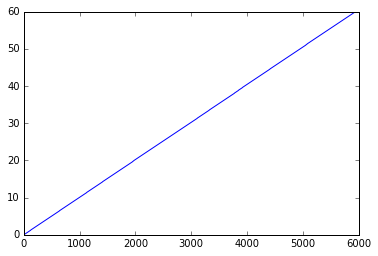

In [47]:
plt.plot(TimeOnFinalFinal)

In [48]:
Fileout="".join(filename[i] for i in range(len(filename)-4))

In [49]:
OutFilename=Fileout+'FluoOn.mat'

In [50]:
OutFilename

'/home/sophie/Desktop/100406ss1TotalTimeOnFluoOn.mat'

In [51]:
sio.savemat(OutFilename, {'TimeFluoOnVid':TimeOnFinalFinal,'ONint':ONint+1,'OFFint':OFFint+1})
